## LSTM VS BERT For AG NEWS Classification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/Fellowship/Data/ag_news_csv/'

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import plotly.express as px
import operator
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Reading our train & test data

In [ ]:
#getting data from drive
df_train = pd.read_csv(path + 'train.csv' , header= None )
df_test = pd.read_csv(path + 'test.csv',header = None)
df_test.columns = ['Class','Title','Description']
df_train.columns = ['Class','Title','Description']
df_train.head()

,Class,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Combining Title & Description of news 

as both are crucial information about the news class.

In [ ]:
df_train['news_text'] = pd.Series(df_train['Title'] + ' ' + df_train['Description'])
df_train.drop(['Title','Description'], inplace = True, axis = 1)
df_train.head()

,Class,news_text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [ ]:
df_test['news_text'] = pd.Series(df_test['Title'] + ' ' + df_test['Description'])
df_test.drop(['Title','Description'], inplace = True, axis = 1)
df_test.head()

,Class,news_text
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


# **EDA** & **DATA PREPROCESSING**

### Checking the shape of data

In [ ]:
print('Shape of train set : {}'.format(df_train.shape))
print('Shape of test set  : {}'.format(df_test.shape))

Shape of train set : (120000, 2)
Shape of test set  : (7600, 2)


In [ ]:
df_train, df_val = train_test_split(df_train, random_state=42, train_size=0.4,test_size=0.06, stratify=df_train.Class.values)

In [ ]:
#df_train = df_train.iloc[0 : 60000, :]

### checking wheteher there are any null(Nan) values in our data

In [ ]:
df_train.isna().sum()

Class        0
news_text    0
dtype: int64

In [ ]:
df_test.isna().sum()

Class        0
news_text    0
dtype: int64

There are no null values in the test as well as train data

* ### Let's see what are the classes we have got in our data

In [ ]:
with open(path+'classes.txt','r') as file_ref:
    print("Classes are as follows : \n")
    for c in file_ref.readlines():
        print(c)

Classes are as follows : 

World

Sports

Business

Sci/Tech



* ### Distribution of class labels in our training dataset



In [ ]:
df_train['Class'].value_counts().sort_index()

1    12000
2    12000
3    12000
4    12000
Name: Class, dtype: int64

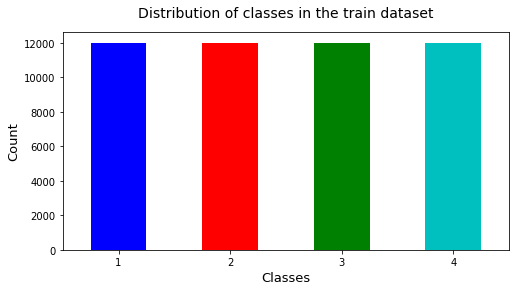

In [ ]:
plt.figure(figsize = (8,4))
ax = df_train['Class'].value_counts().sort_index().plot(kind = 'bar',rot =0, color = ['b','r','g','c'])
ax.set_title('Distribution of classes in the train dataset', fontsize = 14, pad = 15)
ax.set_xlabel('Classes',fontsize = 13)
ax.set_ylabel('Count',fontsize = 13)
plt.show()

* ### Distribution of class labels in our test dataset

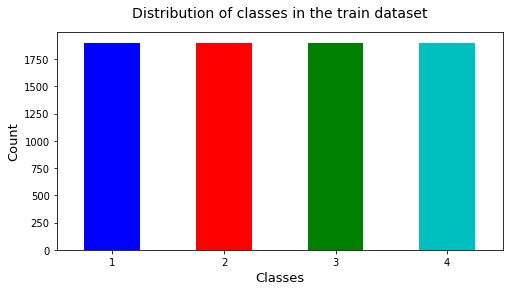

In [ ]:
plt.figure(figsize = (8,4))
ax = df_test['Class'].value_counts().sort_index().plot(kind = 'bar',rot =0, color = ['b','r','g','c'])
ax.set_title('Distribution of classes in the train dataset', fontsize = 14, pad = 15)
ax.set_xlabel('Classes',fontsize = 13)
ax.set_ylabel('Count',fontsize = 13)
plt.show()

Thus, all the classes are balanced.

# **DATA PREPROCESSING**


### Removing punctuation marks from train and test dataset

In [ ]:
import string

string.punctuation 

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# function to remove punctuations
def remove_punc(x):
  #return re.sub('[!#?,.:"\'\;\“\-\_]', '', x)
  return re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]','', x)

In [ ]:
df_train.columns

Index(['Class', 'news_text'], dtype='object')

In [ ]:
df_train.news_text = df_train.news_text.apply(remove_punc)
df_test.news_text = df_test.news_text.apply(remove_punc)

In [ ]:
df_train.head(3)

,Class,news_text
26793,3,Chain Store Sales Increase Slightly Reuters Re...
42817,1,Argentine Teen Kills Three in School Shooting ...
55741,1,Prime Minister Howard reelected in Australia A...


### Converting all the words to lower cases 

In [ ]:
def to_lower(x):
    return x.lower()

In [ ]:
df_train.news_text = df_train.news_text.apply(to_lower)
df_test.news_text = df_test.news_text.apply(to_lower)

In [ ]:
df_train.head(3)

,Class,news_text
26793,3,chain store sales increase slightly reuters re...
42817,1,argentine teen kills three in school shooting ...
55741,1,prime minister howard reelected in australia a...


### Removing stopwords

In [ ]:
def remove_stopwords(x):
    ls = x.split()
    new_ls = []
    stop=stopwords.words('english')

    for i in ls:
        if i not in stop:
            new_ls.append(i)
    return ' '.join(new_ls)        


In [ ]:
df_train.news_text = df_train.news_text.apply(remove_stopwords)
df_test.news_text= df_test.news_text.apply(remove_stopwords)

## removing digits

In [ ]:
df_train.news_text = df_train.news_text.str.replace('\d+','')
df_test.news_text = df_test.news_text.str.replace('\d+','')

* ### Visualizing word clouds for all the four classes of news

* * ### World News

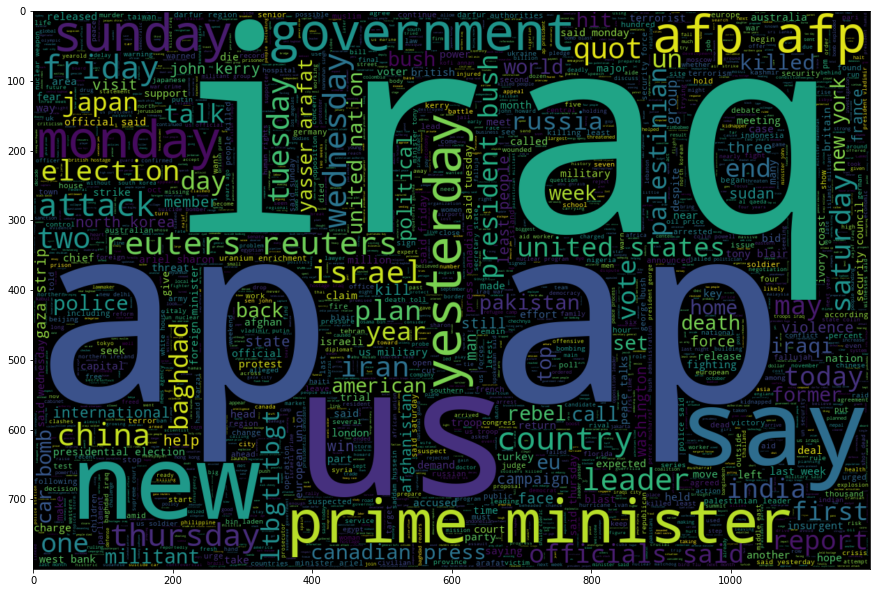

In [ ]:
world = df_train[df_train.Class == 1].news_text
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(world))
plt.imshow(wordcloud,interpolation = 'bilinear')


*  * ### Sports News

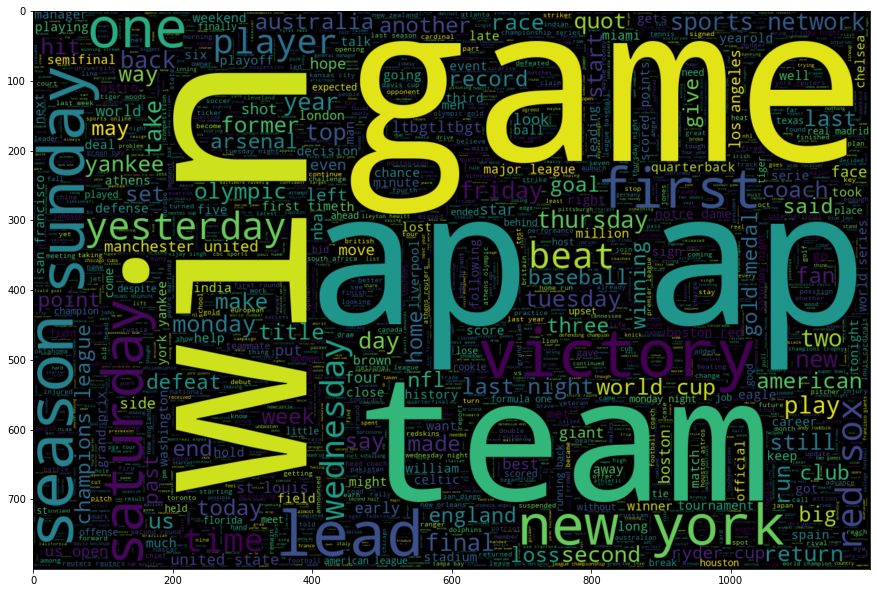

In [ ]:
text = df_train[df_train.Class == 2].news_text
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(text))
plt.imshow(wordcloud,interpolation = 'bilinear')

*  * ### Business News


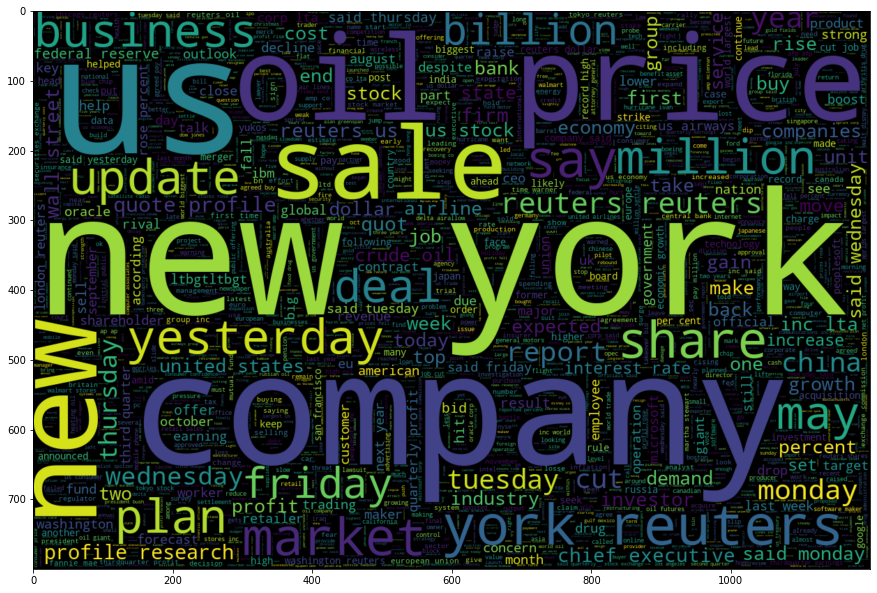

In [ ]:
sports = df_train[df_train.Class == 3].news_text
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(sports))
plt.imshow(wordcloud,interpolation = 'bilinear')

*  *  ### Sci/Tech News

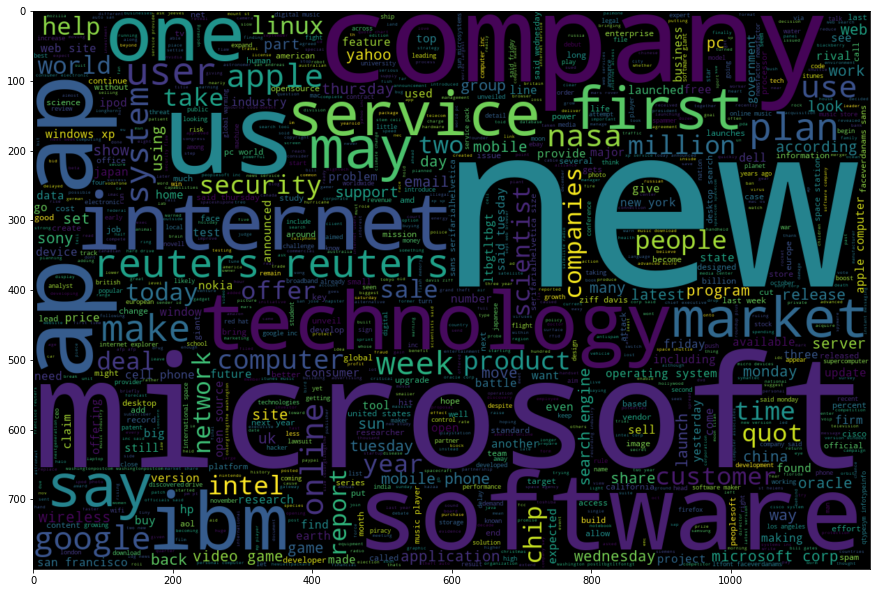

In [ ]:
text = df_train[df_train.Class == 4].news_text
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(text))
plt.imshow(wordcloud,interpolation = 'bilinear')

## Vocabulary

In [ ]:
english_words = []
def get_unique_words(x, word_list):
    for word in x.split():
        if word not in word_list:
            word_list.append(word)

In [ ]:
df_train.news_text.apply(lambda x : get_unique_words(x, english_words));

In [ ]:
english_vocab = len(english_words)
print("Vocabulary size of english. : {}".format(english_vocab))

Vocabulary size of english. : 59661


In [ ]:
english_maxlen = -1
wrd = ''
for word in english_words :
    word_len = len(word)
    if word_len > english_maxlen :
        english_maxlen = word_len
        wrd = word

In [ ]:
print("Maximum length of english word : {} and the word is = {}".format(english_maxlen, wrd))

Maximum length of english word : 122 and the word is = hrefhttpaddoubleclicknetclkuhttpaddoubleclicknetclkdhttpwwwibmcomserverseserverpseriescampaignsboardroomindexhtmlcapseries


### Plotting the frequency of words in each class of news

* #### 1) World News

In [ ]:
eng_words = [ ]
for i in df_train[df_train.Class == 1].news_text:
    for word in i.split():
        eng_words.append(word)

eng_words_counts = Counter(eng_words)
eng_words_counts = sorted(eng_words_counts.items() ,key = operator.itemgetter(1),reverse = True)

# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(eng_words_counts)):
  english_words.append(eng_words_counts[i][0])
  english_counts.append(eng_words_counts[i][1])

english_words = english_words[:200]
english_counts = english_counts[:200]

#Plot barplot using plotly 
fig = px.bar(x = english_words, y = english_counts)
fig.show()

* #### 2) Sports News

In [ ]:
eng_words = [ ]
for i in df_train[df_train.Class == 2].news_text:
    for word in i.split():
        eng_words.append(word)

eng_words_counts = Counter(eng_words)
eng_words_counts = sorted(eng_words_counts.items() ,key = operator.itemgetter(1),reverse = True)

# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(eng_words_counts)):
  english_words.append(eng_words_counts[i][0])
  english_counts.append(eng_words_counts[i][1])

english_words = english_words[:200]
english_counts = english_counts[:200]

#Plot barplot using plotly 
fig = px.bar(x = english_words, y = english_counts)
fig.show()

* #### 3) Buisness News

In [ ]:
eng_words = [ ]
for i in df_train[df_train.Class == 3].news_text:
    for word in i.split():
        eng_words.append(word)

eng_words_counts = Counter(eng_words)
eng_words_counts = sorted(eng_words_counts.items() ,key = operator.itemgetter(1),reverse = True)

# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(eng_words_counts)):
  english_words.append(eng_words_counts[i][0])
  english_counts.append(eng_words_counts[i][1])

english_words = english_words[:200]
english_counts = english_counts[:200]

#Plot barplot using plotly 
fig = px.bar(x = english_words, y = english_counts)
fig.show()

* #### 4) Sci/Tech News

In [ ]:
eng_words = [ ]
for i in df_train[df_train.Class == 4].news_text:
    for word in i.split():
        eng_words.append(word)

eng_words_counts = Counter(eng_words)
eng_words_counts = sorted(eng_words_counts.items() ,key = operator.itemgetter(1),reverse = True)

# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(eng_words_counts)):
  english_words.append(eng_words_counts[i][0])
  english_counts.append(eng_words_counts[i][1])

english_words = english_words[:200]
english_counts = english_counts[:200]

#Plot barplot using plotly 
fig = px.bar(x = english_words, y = english_counts)
fig.show()

##### Finding maximum length of sentence

In [ ]:
#Max Length of sentences in Train Dataset
maxlen = df_train.news_text.map(lambda x: len(x.split())).max()
print('maximum length of a setence  : {}'.format(maxlen))

maximum length of a setence  : 93


## splitting the data

In [ ]:
train_X, valid_X ,test_X = df_train.news_text , df_val.news_text ,df_test.news_text
train_Y , test_Y = df_train.Class.apply(lambda x : x-1) , df_test.Class.apply(lambda x : x-1)# Class labels need to begin from 0
valid_Y = df_val.Class.apply(lambda x:x-1)

## Tokenization & Padding

Padding : is applied so that our neural network can have all inputs of same size.

In [ ]:
vocab_size = english_vocab # calculated above
embed_size = 128

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(train_X.values)

# Tokenize data
train_X = tok.texts_to_sequences(train_X)
valid_X = tok.texts_to_sequences(valid_X)
test_X = tok.texts_to_sequences(test_X)

# Pad data
train_X = pad_sequences(train_X, maxlen=maxlen)
valid_X = pad_sequences(valid_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Building the Model --> **LSTM**

**Word Embeddings** Definition Word embeddings are a type of word representation that look at the context of words which allows words with similar meaning to have a similar vector representation.


1. Each word is represented as  a vector.

2. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

3. They can be considered an improvement over sparse representations used in simpler bag of word model representations.

**LSTM** Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

In [ ]:
import tensorflow
tensorflow.keras.backend.clear_session()

In [ ]:

vocab_size 

59661

In [ ]:

model = Sequential()
model.add(Embedding(vocab_size, 256 , input_length = maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64 , return_sequences = True)))
model.add(Bidirectional(LSTM(32 , return_sequences = True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
#model.add(Dense(128))
#model.add(Dropout(0.5)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(16))
model.add(Dropout(0.25))

model.add(Dense(4, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 93, 256)           15273216  
_________________________________________________________________
bidirectional (Bidirectional (None, 93, 256)           394240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 93, 128)           164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 93, 64)            41216     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

## Using callback for **early stopping**

A **callback** is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [ ]:
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience= 3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

## Running the model

In [ ]:
opt = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer= opt, 
              metrics=['accuracy']) 

history = model.fit(train_X, 
          train_Y, 
          batch_size= 256, 
          validation_data=(valid_X, valid_Y), 
          epochs=20, 
          callbacks=callbacks)

Epoch 1/20
188/188 [==============================] - 51s 235ms/step - loss: 1.2876 - accuracy: 0.3864 - val_loss: 0.6854 - val_accuracy: 0.7489

Epoch 00001: val_accuracy improved from -inf to 0.74889, saving model to weights.h5
Epoch 2/20
188/188 [==============================] - 41s 217ms/step - loss: 0.3813 - accuracy: 0.8834 - val_loss: 0.7453 - val_accuracy: 0.7367

Epoch 00002: val_accuracy did not improve from 0.74889
Epoch 3/20
188/188 [==============================] - 40s 215ms/step - loss: 0.2715 - accuracy: 0.9248 - val_loss: 0.8733 - val_accuracy: 0.7226

Epoch 00003: val_accuracy did not improve from 0.74889
Epoch 4/20
188/188 [==============================] - 41s 217ms/step - loss: 0.2080 - accuracy: 0.9479 - val_loss: 1.2683 - val_accuracy: 0.6467

Epoch 00004: val_accuracy did not improve from 0.74889
Epoch 00004: early stopping


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

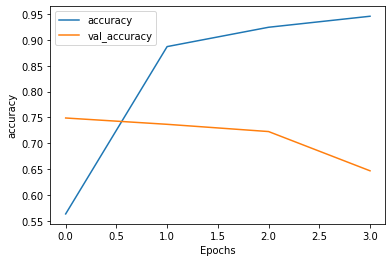

In [ ]:
plot_graphs(history, 'accuracy')

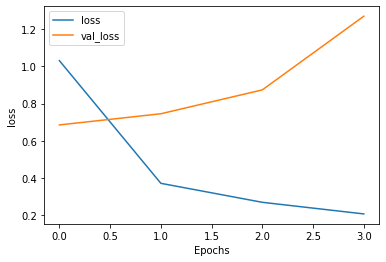

In [ ]:
plot_graphs(history, 'loss')

## Model Evaluation on Test data

In [ ]:
model.evaluate(test_X,test_Y,batch_size = 128, verbose=1)

60/60 [==============================] - 1s 20ms/step - loss: 0.3757 - accuracy: 0.8864


[0.3757075071334839, 0.8864473700523376]

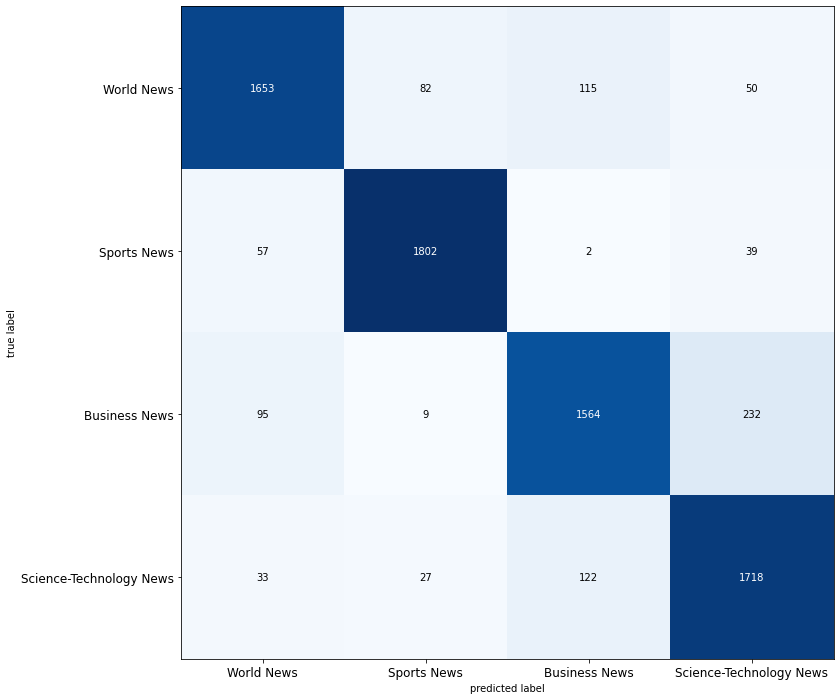

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(test_X)]
cm  = confusion_matrix(test_Y, preds)

plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [ ]:
print("Recall of the model is {:.2f}".format(recall_score(test_Y, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(test_Y, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(test_Y, preds)))

Recall of the model is 0.89
Precision of the model is 0.89
Accuracy of the model is 0.89


We can see that our model is overfiiting from the training and validation accurarcy . Though shown a good performance on test data i.e 89% accuracy.

We can avoid this problem by using 
* differnt regularization technique lile L2 & Dropout with different parameter values. 
* Trying to use Data Augmentation techniques speicific to text data.
* Differnt network archictectures.

As we know that neural networks are data hungary and with the provided compute resource like google colab, we become restricted to use certain amout of data. So if provided with the good computing power we can overcome the variance problems.

# MODEL - **BERT**

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1382 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 26.73 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
!pip install -Uqr models/official/requirements.txt


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


loading original data as raw data will be provided to the BERT model and necessary representations will be learnt by the model itself.


We will not pre-process the data for BERT.

In [ ]:
df_train = pd.read_csv(path + 'train.csv' , header= None )
df_test = pd.read_csv(path + 'test.csv',header = None)
df_test.columns = ['Class','Title','Description']
df_train.columns = ['Class','Title','Description']

In [ ]:
#train
df_train['news_text'] = pd.Series(df_train['Title'] + ' ' + df_train['Description'])
df_train.drop(['Title','Description'], inplace = True, axis = 1)
#test
df_test['news_text'] = pd.Series(df_test['Title'] + ' ' + df_test['Description'])
df_test.drop(['Title','Description'], inplace = True, axis = 1)
df_train.Class , df_test.Class = df_train.Class.apply(lambda x : x-1), df_test.Class.apply(lambda x : x-1) # Class labels need to begin from 0


In [ ]:
df_test.Class.value_counts()

0    1900
1    1900
2    1900
3    1900
Name: Class, dtype: int64

## Downsampling the data using stratified sampling

In [ ]:
df_train.shape , df_test.shape

((120000, 2), (7600, 2))

In [ ]:
train_df, valid_df = train_test_split(df_train, random_state=42, train_size=0.4,test_size=0.06, stratify=df_train.Class.values)

In [ ]:
train_df.shape, valid_df.shape #checking the shape of our data

((48000, 2), (7200, 2))

In [ ]:
train_df.Class.value_counts()

0    12000
1    12000
2    12000
3    12000
Name: Class, dtype: int64

In [ ]:
valid_df.Class.value_counts()

0    1800
1    1800
2    1800
3    1800
Name: Class, dtype: int64

## Create tf.data.Datasets for Training and Evaluation

The tf.data.Dataset API supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

* Create a source dataset from your input data.
* Apply dataset transformations to preprocess the data.
* Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.news_text.values, train_df.Class.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.news_text.values, valid_df.Class.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Chain Store Sales Increase Slightly (Reuters) Reuters - U.S. chain store sales increased\\slightly in the latest week, due in part to Labor Day sales and\\back-to-school shopping, a report said on Tuesday.', shape=(), dtype=string)
tf.Tensor(2, shape=(), dtype=int64)


## Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1, 2, 3] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
#vocab file contains a mapping from vocabulary strings and indices used for embedding lookup in the model
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
#checking whether inputs have been uncased or not
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() 
#using tokenizer of BERT model
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

## Tokenize and Preprocess Text for BERT

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using classifier_data_lib's constructor InputExample provided in the BERT library.



In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, #as we are dealing with only one senetence at a time
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

we will use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So we can't `.map` this function directly: We need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

## Create a TensorFlow Input Pipeline with tf.data

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE) #figure out what the optimal number of parallel calls should be
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid 
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

The resulting tf.data.Datasets return (features, labels) pairs, as expected by keras.Model.fit:

In [ ]:
# data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Add a Classification Head to the BERT Layer

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  ##we are intereseted in pooled_output
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(4, activation="softmax", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

## Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

Plot of the architecture

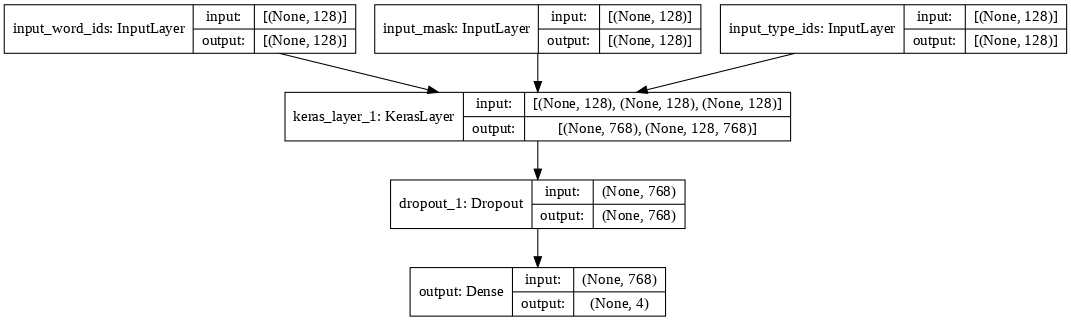

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

## Using callback for **early stopping**

A **callback** is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [
    EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
        monitor='val_accuracy',
        min_delta=1e-4,
        patience= 4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='bert_weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [ ]:
# Train model
epochs = 16
history = model.fit(train_data,
                    validation_data= valid_data,
                    epochs=epochs,
                    verbose=1,
                    callbacks= callbacks)

Epoch 1/16
1500/1500 [==============================] - 1279s 852ms/step - loss: 0.2652 - accuracy: 0.9094 - val_loss: 0.1962 - val_accuracy: 0.9337

Epoch 00001: val_accuracy improved from -inf to 0.93375, saving model to bert_weights.h5
Epoch 2/16
1500/1500 [==============================] - 1287s 857ms/step - loss: 0.1581 - accuracy: 0.9471 - val_loss: 0.1778 - val_accuracy: 0.9371

Epoch 00002: val_accuracy improved from 0.93375 to 0.93708, saving model to bert_weights.h5
Epoch 3/16
1500/1500 [==============================] - 1290s 859ms/step - loss: 0.1003 - accuracy: 0.9663 - val_loss: 0.2142 - val_accuracy: 0.9369

Epoch 00003: val_accuracy did not improve from 0.93708
Epoch 4/16
1500/1500 [==============================] - 1300s 866ms/step - loss: 0.0645 - accuracy: 0.9780 - val_loss: 0.2540 - val_accuracy: 0.9324

Epoch 00004: val_accuracy did not improve from 0.93708
Epoch 5/16
1500/1500 [==============================] - 1300s 866ms/step - loss: 0.0410 - accuracy: 0.9860 - 

## Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

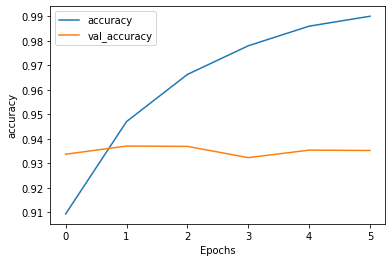

In [ ]:
plot_graphs(history, 'accuracy')

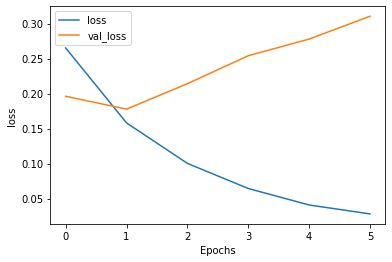

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
model.evaluate(valid_data, verbose=1)

225/225 [==============================] - 62s 274ms/step - loss: 0.3104 - accuracy: 0.9353


[0.310449481010437, 0.9352777600288391]

## Evaluating BERT MODEL on test data

In [ ]:
#making test data into required format
test_data = tf.data.Dataset.from_tensor_slices((df_test.news_text.values, df_test.Class.values))
test_data = (test_data.map(to_feature_map).batch(1))

In [ ]:
#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
#converting all the target variable values into numpy array for evaluation purpose
y_ls = []
c = 0
for x , y in test_data:
    y_ls.append(y.numpy()[0])      

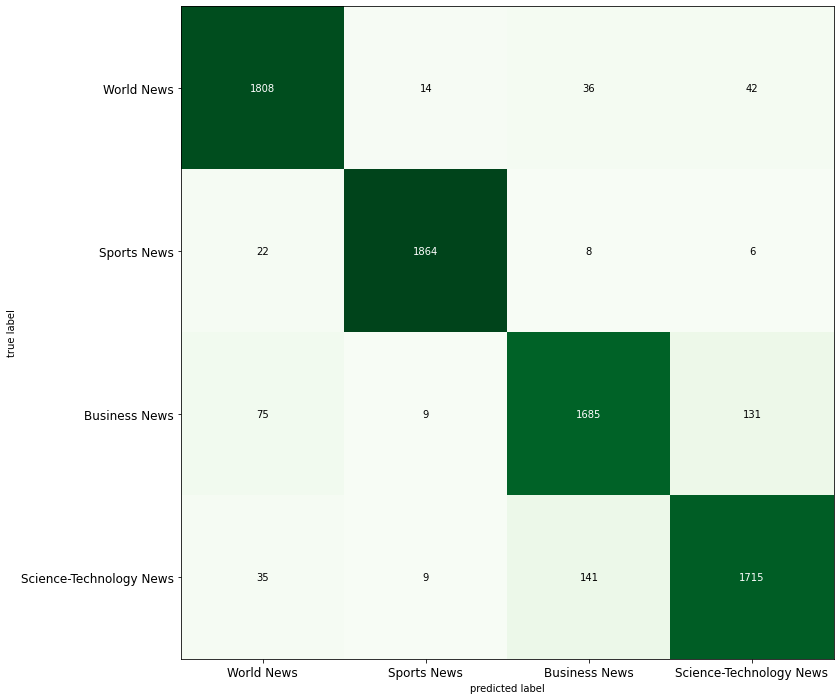

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(test_data)]
cm  = confusion_matrix(y_ls, preds)

plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Greens)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [ ]:
print("Recall of the model is {:.2f}".format(recall_score(y_ls, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_ls, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_ls, preds)))

Recall of the model is 0.93
Precision of the model is 0.93
Accuracy of the model is 0.93


In [ ]:
model.evaluate(test_data, verbose=1)

7600/7600 [==============================] - 93s 12ms/step - loss: 0.3225 - accuracy: 0.9305


[0.3224504888057709, 0.9305263161659241]

* WE can see that BERT has performed very well on our test data and has a lower overfitting magnitude. It's performance can be incresed by using more data or using data augmentation techniques. Using hyperparameter tuning and different architecture.

Though availability of compute resources restrict us doing experiments with our model .


### Conclusion

* WE can see that BERT has performed better than our LSTM model , one of the reason is that in our traditional word embedding we have only one vector representation for each word whereas BERT uses Contextual embedding i.e word vector represenatitions depending in the contexts they have been used.

* Other observation is that Bert has significant lower overfitting magnitude than our LSTM model.